# Simulate gamma ray sources in galaxy

## Imports and definitions

In [1]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker
import makemap
rc('font',**{'family':'serif'})
rc('text',usetex=True)

##colors
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
colors = [c1,c2,c3,c4,c5,c6,c7,c8,c9]

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm

##SNR distribution From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004

Rsun = 8.3
hb = 10 #This is considered as high latitude

##This is for pulsars
model = 'SNR' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
if model=='SNR':
    H = 0.083
    alp = alp_snr
    bet = bet_snr
#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.

#lb regions
lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)

###From tevcat 
Lmin_tev = 3.96e34
Lmax_tev = 1.79e38

## Function definitions

In [2]:
#Function definitions
from scipy.stats import expon
##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_R_norm(n,mu,sig):
    "return normal random"
    return np.random.normal(mu,sig,n)

def rand_R_SNI(n,a,Rsun=Rsun):
    return np.random.exponential(a,n)

def R_SNR_ferriere(R):
    sig1 = 4.8*np.exp(-(R-Rsun)/4.5)
    sig2 = 27*np.where(R < 3.7,3.55*np.exp(-((R-3.7)/2.1)**2),
                   np.exp(-(R**2-Rsun**2)/6.8**2))
    return sig1+sig2

rspace = np.linspace(0,30,1000)
data_r = R_SNR_ferriere(rspace)
data_r = data_r/np.sum(data_r) #normalize
data_r_cdf = np.cumsum(data_r)#cdf

# def rand_R_SNR_ferriere(N):
#     R_smpl = np.zeros(N)
#     r = np.linspace(0,30,1000)
#     data_r = R_SNR_ferriere(r)
#     data_r = data_r/np.sum(data_r) #normalize
#     data_r_cdf = np.cumsum(data_r)#cdf
#     u = np.random.rand(N)
#     for i in range(N):
#         #Inverse transform sampling, numerical
#         xx= np.argmax(u[i]<=data_r_cdf)
#         R_smpl[i]=r[xx]
#     return R_smpl

def ITS(N,x,cdf):
    smpl = np.zeros(N)
    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        ix= np.argmax(u[i]<=cdf)
        smpl[i]=x[ix]
    return smpl

atest=[(1.09,3.98),(0.2,1.4),(1.9,5.0)]
labels = ['SNR Green','Lorimer S','Lorimer C', 'Ferriere SNRI+II']

f,ax = plt.subplots(1,figsize=(7,5))
for i,a in enumerate(atest):
    ax.hist(rand_R(30000,a[0],a[1]),bins=np.linspace(0,25),label=labels[i],histtype='step',color=colors[i+3])

    
ax.hist(ITS(30000,rspace,data_r_cdf),bins=np.linspace(0,25),label=labels[3],histtype='step',color=colors[i+4])
ax.set_xlim([0,20])
ax.set_xlabel(r'$R \ \mathrm{[kpc]}$',fontsize=16)
ax.set_ylabel(r'Number of sources',fontsize=16)
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
plt.legend(frameon=False,fontsize=16)
#plt.savefig('R_hist.pdf')

plt.close('all')


def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def z_SNR_ferriere(z):
    "z in pc"
    R1 = 7.3*np.exp(-np.abs(z)/325.)
    R2 = 50 * (0.79*np.exp(-(z/212.)**2)+0.21*np.exp(-(z/636.)**2))
    return R1+R2

zspace = np.linspace(-3000,3000,1000)
data_z = z_SNR_ferriere(zspace)
data_z = data_z/np.sum(data_z) #normalize
data_z_cdf = np.cumsum(data_z)#cdf

def rand_z_SNR_ferriere(N):
    z_smpl = np.zeros(N)

    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        xx= np.argmax(u[i]<=data_z_cdf)
        z_smpl[i]=z[xx]
    return z_smpl/1000. #kpc

    

def rand_L(u,a,Lmin,Lmax):
    """Random L generator. Uses inverse transform sampling.
        u is a uniform random number between 0-1, a is the index of the
        power law distributiond desired.
        L = CDF^-1(u)
    """
    if a==1:
        print "a==1, error" #does not work for this..
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

# Ltest = [1.5,1.8,2.1]
# f,ax = plt.subplots(1,figsize=(7,5))
# for i,l in enumerate(Ltest):
#     ax.hist(rand_L(np.random.rand(30000),l,2e34,2e39),bins=np.logspace(34,39,25), color=colors[i],
#            label='index = %s'%l,histtype='step',log=True)
#     ax.set_xscale('log',nonposx='clip')
#     ax.set_xlabel(r'Luminosity $\rm{ph \ s^{-1}}$',fontsize=16)
#     ax.set_ylabel(r'Number of sources',fontsize=16)
#     ax.set_ylim([0.1,2e4])
#     ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# plt.savefig('lum_hist.pdf')

def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    """
    Reads the catalog, either 3FGL or 3FHL, and returns the average 
    spectrum of the desired sources.
    
    Still have to adjust so that it returns the right spectrum...
    
    Returns also the histogram counts vs flux
    """
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        _E = E3fgl
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        _E = Efhl
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)

    for m in classes:
        mask = (cls==m)|mask
    
#     snr = tb[mask]
#     tev =snr['ASSOC_TEV']
#     snr_tev = snr[np.char.rstrip(tev, ' ')!='']
#     #print snr_tev['ASSOC_TEV']
#     dist_tb = [3.5,2,2,1.5,0.29,0.2,6.6,5.2,None,6.5,None,8.6,None,1,7.9,11.5,None,8.3,2,6,3.7,3.9,4,6.6,None,4.3,None,0.8,3.4]
#     dist_tb = np.array(dist_tb)
#     mask_dist = dist_tb!=None
#     L_tev = snr_tev['Flux1000'][mask_dist]*(4*np.pi*(dist_tb[mask_dist]*kpc)**2).tolist()
#     print "Lowest lum SNR from TeVCAT",min(L_tev),snr_tev['ASSOC_TEV'][np.argmin(L_tev[L_tev != np.amin(L_tev)])]
#     print "Max lum SNR from TeVCAT", max(L_tev)
    
    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    if catalog == 'fhl':
        flux = tb[mask]['Flux']

    spec = catalog_spect.get_spec(fn) ###This function returns the spectra of the catalogue
    
    spec = spec[mask]

    #for sp in spec:
    #    plt.loglog(_E,_E**2*sp,color='gray')
    ave_spec = 10**np.average(np.log10(spec),axis=0)
    #ave_spec = np.average(spec,axis=0)
    #ave_spec = np.average(spec,axis=0)
    #plt.loglog(_E,_E**2*np.average(spec,axis=0),color='b',lw=5)
    
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)

    if catalog=='fgl':
        ind = np.mean(tb[mask]['Spectral_Index'])
    if catalog=='fhl':
        ind = np.mean(tb[mask]['PowerLaw_Index'])

    plotfunc = lambda E,a,b: b*(E)**-a
    #plt.loglog(_E,_E**2*plotfunc(_E,2.25,1e-8),color='r',lw=3)
    #plt.ylim([1e-10,1e-5])
   # spec = plotfunc(E,ind,1)
   # spec = ave_spec
    #good_spec = norm_spec(spec,total_flux,dE,mask_E)

    #spec_normed = good_spec/np.max(good_spec)

    return hist_3fgl,ave_spec,spec#spec_normed,ind

## Load catalogue

In [24]:
##Load 3fgl data and get average spectrum and histogram of fluxes from here
###The spectrum was fitted so that we can use the analytical expression bellow. So this is now not really needed.
##

file_3fgl = 'gll_psc_v16.fit'
func_log = lambda E,p: p[0]*(E/p[1])**(-p[2]-p[3]*np.log(E/p[1]))
func_Exp = lambda E,p: p[0]*(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4])

###Only hard sources (SNR and PWN (spp=either of those not identified))
hist_3fgl_snr,intp_3fgl_snr_normed,spec_3fgl_snr = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['pwn','snr','spp'])
###All galactic sources
hist_3fgl_all,intp_3fgl_all_normed,spec_3fgl_psr = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                           classes=['psr'])

intp_3fgl_snr_normed = E**-2.2
# hist_3fhl_snr,intp_3fhl_snr_normed,spec_3fhl_snr = read_catalog('gll_psch_v13.fit',catalog='fhl',
#                                                           classes=['pwn','snr','spp'])
# hist_3fhl_all,intp_3fhl_all_normed,spec_3fhl_psr = read_catalog('gll_psch_v13.fit',catalog='fhl',
#                                                           classes=['psr'])

#plt.loglog(E3fgl,E3fgl**2*intp_3fgl_snr_normed)
#plt.loglog(Efhl,Efhl**2*intp_3fhl_snr_normed)
f = lambda E,Ebr,p: p[0]*np.where(E <Ebr,(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4]),
                                  (Ebr/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(Ebr/p[3])**p[4])*(E/Ebr)**-p[5])

Ebr = 100

###


##These values are the best fitted values, normalization does not matter, will be fixed later
#intp_3fgl_all_normed = f(E,Ebr,[1,1,1.7,3.1,0.89,3.4])
# f,ax = plt.subplots(1,figsize=(8,5))
# for sp in spec_3fgl_psr:
#     ax.loglog(E3fgl,E3fgl**2*sp,color=colors[1],alpha=0.3,zorder=2)

# ax.loglog(E3fgl,E3fgl**2*intp_3fgl_all_normed,color=colors[1],label='3FGL: PSR',alpha=1,lw=4,zorder=9)
# for sp in spec_3fgl_snr:
#     ax.loglog(E3fgl,E3fgl**2*sp,color=colors[5],alpha=0.3,zorder=1)

# ax.loglog(E3fgl,E3fgl**2*intp_3fgl_snr_normed,color=colors[5],label='3FGL: SNR and PWN',alpha=1,lw=4,zorder=10)

# #ax.loglog(Efhl,Efhl**2*intp_3fhl_all_normed, ls='--',color=colors[1],label='3FHL: all galactic sources')
# #ax.loglog(Efhl,Efhl**2*intp_3fhl_snr_normed,ls='--',color=colors[5],label='3FHL: SNR and PWN')

# ax.set_ylim([1e-12,1e-5])
# ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# #ax.get_yaxis().set_ticks([])
# ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$",fontsize=14)
# ax.set_xlabel(r"$E$ [GeV]",fontsize=14)
# plt.legend(frameon=False,fontsize=14,loc=1)
# # plt.savefig('unres_source_spec.pdf')

## Load diffuse data

In [25]:
###Load the data from a skyfact run. Uses the 7rings run to get spectra in either of those rings

import open_dat
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)

fit_rings_spec_27 = []
fit_rings_spec = []
dat_rings = open_dat.open_dat('r5_fulldisk_7rings3_spectra.dat')
deltaE = dat_rings['delta_e']
E_diff = dat_rings['emean']
mask_E_diff = E_diff > 2
Ec = 30
sr =0.5*0.5*np.radians(1)**2*(720*81)

###Fitted indices
index_bay = np.loadtxt('index_r5_fulldisk_7rings3.dat')

def errfunc(theta,f,x,y,yerr):
    """leastsq function"""
    if isinstance(yerr,int):
        yerr = yerr
    else:
        yerr = yerr/(np.log10(10)*y)
    x = np.log10(x)
    y = np.log10(y)
    model = f(x,theta)
    return np.sum(((y-model)/yerr)**2)

from scipy import optimize

fitf = lambda *args: errfunc(*args)

modelfunc = lambda x,p: p[0]-p[1]*x

fitfunctie = lambda x,p1,p2: p1-p2*x

model27 = lambda x,p: p[0]-2.7*x

p0 = [-7,2.7]

def fit_index(E,flux,error=1,model=modelfunc,p0=p0):
    #fit,cov = curve_fit(model,np.log10(E),np.log10(flux),sigma=error/(np.log10(10)*flux),p0=p0)
    res = optimize.minimize(fitf,p0,args=(model,E,
                                            flux,error))
    return res["x"],res["hess_inv"]
    #return fit,cov
    
####
###Load the indices as fitted by bayfit.py
fl_indices = 'index12_r5_fulldisk_7rings3_.dat'
sf_2_200 = []
sf_2_200_err = []
with open(fl_indices, 'r') as fl:
    lines = fl.readlines()
    for l in lines[1::2]:
        l = l.split()
        try:
            sf_2_200.append(-float(l[0]))
            sf_2_200_err.append(float(l[1]))
        except:
            print "oops"

for d in sorted(dat_rings):
    if 'Gas' in d and not 'err' in d:
        spec = sr*dat_rings[d]/deltaE

        err =dat_rings[d+'_err']/deltaE
        fit,cov = fit_index(E_diff[mask_E_diff],spec[mask_E_diff],err[mask_E_diff],model=modelfunc,p0=[-7,2.7])
        ###Fit the spectrum with index=2.7, to get a powerlaw spectrum fixed to this. So just to fit the norm
        fit27,cov27 = fit_index(E_diff[mask_E_diff],spec[mask_E_diff],err[mask_E_diff],model=model27,p0=[-7])
          
        fit_rings_spec_27.append(plotfunc(E,2.7,10**fit27[0])) 
        fit_rings_spec.append(plotfunc(E,fit[1],10**fit[0]))
R_rings = [(0,1.7),(1.7,4.5),(4.5,6.5),(6.5,8.0),(8.0,10.0),(10.0,16.5),(16.5,50)]
R = np.array(R_rings)

In [26]:
###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.
###This has some overlap with above...

import open_dat

def read_datfile(datFile):
    "Read dat file and return total gas spec (sum)"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    
spec_diff_lb = []
diff_index_lb = []
spec_27_l = []
spec_dat = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
for ilb in lb:
    datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    spec_dat.append(spec)
    mask_E_diff = E_diff > 2
    E_diff2 = E_diff
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    err = error[mask_E_diff]
    
    fit,cov = fit_index(E_diff,spec,err,model=modelfunc,p0=[-7,2.7])
    fit27,cov27 = fit_index(E_diff,spec,err,model=model27,p0=[-7])

    ####
    ####This matters a lot!
    diff_index = fit[1]

    fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!

    spec_diff_lb.append(fitted_spec)


## Simulate sources

In [27]:
###Define some plot functions, plot spectra at the rings and plot the fitted indices
def plot_spec(R_spec,std_R,plot=False):
    """
    This function plots the spectra of the diffuse emission as measured (A) and the diffuse emission if the 
    powerlaw index was uniform (B) with the spectrum of unresolved sources (C) and added together to see if A=B+C
    
    returns the fitted indices of B+C
    """
    snr_spec_R = np.array(R_spec)
    std_snr_spec_R = np.array(std_R)
  
    if plot:
        fig = plt.figure(figsize=(10,14))
        gs = gridspec.GridSpec(4,2)
    
    iE100 = np.argmin(E<100)
    l_i_30 = []
    l_i_200 = []
    err_i_30 = []
    err_i_200 = []
    mask_E_2_30 = (E>=2)&(E<30)
    mask_E_30_200 = (E>=30)&(E<230)
    mask_E_2_200 = (E>=2)&(E<230)

    for ri in range(len(R_rings)):
        spec_sim_diff_unres = fit_rings_spec_27[ri]+snr_spec_R[ri]
        if plot:
            gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[ri])
            ax = plt.Subplot(fig,gs[ri]) 
            ax.loglog(E,E**2*fit_rings_spec_27[ri],label='Diffuse emission (index=2.7)',linestyle='--',color=c2)
            ax.loglog(E,E**2*(spec_sim_diff_unres),label='Diffuse (2.7) + Unresolved Sources',linestyle='-',color=c4)
            ax.fill_between(E,E**2*(spec_sim_diff_unres-std_snr_spec_R[ri]),
                            E**2*(spec_sim_diff_unres+std_snr_spec_R[ri]),alpha=0.2,facecolor=c4)

            ax.loglog(E,E**2*fit_rings_spec[ri],linestyle=':',label='Diffuse emission data (index varies)',color=c3)

            ax.loglog(E,E**2*snr_spec_R[ri],linestyle='-',label='Unresolved Sources',color=c6)

            ax.fill_between(E,E**2*(snr_spec_R[ri]-std_snr_spec_R[ri]),
                            E**2*(snr_spec_R[ri]+std_snr_spec_R[ri]),alpha=0.2,facecolor=c6)

            ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)

            ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$")
            ax.set_xlabel(r"$E$ [GeV]")
            ax.set_title('Full ROI')
            ymin = 0.1*min(1000**2*spec_sim_diff_unres)
            ymax = 10*max(spec_sim_diff_unres)
            if np.isfinite(ymin) and np.isfinite(ymax):
                ax.set_ylim([ymin, ymax])
            ax.set_xscale('log',nonposx='clip')
            ax.set_yscale('log',nonposy='clip')
            ax.set_title(r'R: %s - %s kpc'%R_rings[ri])

            fig.add_subplot(ax)
            plt.legend(loc=0,frameon=False)
        
        fit,cov = fit_index(E[mask_E_2_200],spec_sim_diff_unres[mask_E_2_200],std_snr_spec_R[ri][mask_E_2_200])

        l_i_200.append(fit[1])

        err_i_200.append(np.sqrt(cov[1][1]))
    
    if plot:
        fig.tight_layout(rect=[0, 0.03, 1, 0.95]);
    return l_i_200,err_i_200
    plt.savefig('spec_diff+unres_29000_3FGL_hard_norm.pdf',bbox_inches='tight')

def plot_trend(l_i,l_i_err,options=['test']):
    """
    Plot the trend accros the rings of the fitted index of unresolved+diff(2.7) emission
    """
    #Plot R trend
    #f2,ax2 = plt.subplots(1,figsize=(9.5,5))
    f2,ax2 = plt.subplots(1,figsize=(15,8))
    ax2.errorbar(np.mean(R,axis=1),sf_2_200,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=sf_2_200_err,
                marker='s',linestyle='',color='k',label='Diffuse data')
    for ij, il in enumerate(l_i):
    
        ax2.errorbar(np.mean(R,axis=1),il,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=l_i_err[ij],
                 marker='o',linestyle='',label=options[ij],alpha=0.8)
    #if l_i2 !=None:
    #    ax2.errorbar(np.mean(R,axis=1),l_i2,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=l_i2_err,
    #             color=c3,marker='o',linestyle='',
    #                 label=r'Diffuse(2.7)+unresolved PS (threshold$=5 \times 10^{-9}$)')  
    
    ax2.set_xlim([0,35]);
    ax2.set_ylim([2.1,3.2]);
    plt.minorticks_on()
    ax2.set_xlabel(r'$R \ [\mathrm{kpc}]$',fontsize=16)
    ax2.set_ylabel(r'Spectral index',fontsize=16)
    ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    plt.legend(loc=4,frameon=False,fontsize=15,bbox_to_anchor=[1,0],ncol=2)
    plt.savefig('index_unresolved_options.pdf')

In [47]:
##This is the galaxy simulation
#Do the simulation of sources

def source_sim(a=1.8,N=30000,Lmin=2e34,Lmax=2e39,alpha=alp,beta=bet,H=H,
            SNR=False,PSR=False,f_t=5e-10,flux_cutoff=1e-20,spectrum=intp_3fgl_snr_normed):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N,H)
    R_smpl = rand_R(N,alpha,beta)
    #R_smpl = ITS(N,rspace,data_r_cdf)
    #z_smpl = ITS(N,zspace,data_z_cdf)/1000. #kpc


    #f,ax = plt.subplots(1, figsize=(7,5))
 #   hist,bins = np.histogram(L_smpl, bins=np.logspace(34,39,50))
    #hist,bins = np.histogram(R_smpl,bins=np.arange(0,25))
    #mean_bins = (bins[0:-1]+bins[1:])/2.
    #ax.set_yscale('log',nonposy='clip')
    #ax.set_xscale('log',nonposx='clip')
    #ax.bar(bins[:-1],hist,width=1,color=c2,align='edge')
    #ax.set_xlabel(r'$R \ \mathrm{[kpc]}$')
    #ax.set_ylabel(r'Number of sources')
    
    #plt.savefig('R_hist_SNR.pdf')

        
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)
    #print np.mean(dist)
    ##Calculate longitude and latitude
    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    mask_flux = flux_data < f_t
    meandist = np.mean(dist[flux_data > 5e-9])
    mp = makemap.makemap(l[mask_flux],b[mask_flux],flux_data[mask_flux],0.5)
    ##Fluxes at different R
    spec_R_unres = []
    flux_R_unres = []
    allsky_unres_flux = np.sum(flux_data[mask_flux])
    for rr in R_rings:
        mask_R = (R_smpl >= rr[0])&(R_smpl < rr[1])
        total_flux_R = flux_data[mask_R]
        flux_R_unresolved = np.sum(total_flux_R[total_flux_R<f_t])
        flux_R_unres.append(flux_R_unresolved)
        spec_sim_R = norm_spec(spectrum,flux_R_unresolved,dE,mask_E)
        spec_R_unres.append(spec_sim_R)
       
    #Fluxes at different regions,lb
    spec_unres = []
    frac = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<f_t]
        #flux_unresolved[flux_unresolved<flux_cutoff]=0 #cutoff the lowest of lowest flux (not really necessary)
        total_flux_unres = np.sum(flux_unresolved)
        spec_sim = norm_spec(spectrum,total_flux_unres,dE,mask_E)
        diffuse = spec_diff_lb[ilb]
        frac.append(spec_sim/diffuse)
        spec_unres.append(spec_sim)

#     return hist,dict_flux_lb,frac,spec_unres,spec_R_unres
    return hist,spec_R_unres,frac,mp#,flux_R_unres#,mp

In [48]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources
##Get average and std from Nsmpl runs, plot histogram to compare with hist of 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=10000,LF_i_snr=1.5,Lmin_snr=1e33,Lmax_snr=4e38,
                ft=fermi_thres,flux_cutoff = 1e-20,source_class='SNR',
                plothist=False,printstatements=False,alpha=alp_snr,beta=bet_snr,H=H_snr,
                hist_3fgl=hist_3fgl_snr,spectrum=intp_3fgl_snr_normed):

    print "Doing %s sample galaxys with %s sources,LF_i = %s, Lmin = %s,Lmax=%s, this might take some time..."%(Nsmpl
                                                                                                                ,Nsnr,LF_i_snr,
                                                                                                                Lmin_snr,
                                                                                                                Lmax_snr)
    mdist = 0
    fluxes_snr = []
    hist_snr = np.zeros((Nsmpl,len(bins_mean)))
    frac_snr = []
    spec_snr = []
    spec_R = []
    unres_flux = []
    l_map = []
    if source_class == 'SNR':
        SNR=True
        PSR = False
    elif source_class == 'PSR':
        PSR=True
        SNR=False
    else:
        
        print "unknown source class, use PSR or SNR"
    for i in range(Nsmpl):
        if i%(Nsmpl/10.)==0 and printstatements:
            print 100*i/float(Nsmpl),"% done"
        hist_snr[i,:],ispec_R,frac_lb,mapje = source_sim(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alpha,beta,H,SNR=SNR,PSR=PSR,f_t=ft,
                                                             flux_cutoff=flux_cutoff,spectrum=spectrum)
     
        frac_snr.append(frac_lb)
        spec_R.append(ispec_R)
        #unres_flux.append(as_unres_flux)
        l_map.append(mapje)


    ave_hist_snr = np.rint(np.mean(hist_snr,axis=0))
    std_hist_snr = (np.std(hist_snr,axis=0))
    ave_spec_R = np.average(spec_R,axis=0)
    std_spec_R = np.std(spec_R,axis=0) 
    ave_frac_lb = np.mean(frac_snr,axis=0)
    std_frac_lb = np.std(frac_snr,axis=0)
    mask_complete = (bins_mean >= 5e-9)
    counts_snr = np.sum(ave_hist_snr[mask_complete])
    counts_3fgl_snr = np.sum(hist_3fgl[mask_complete])
    ave_map = np.mean(l_map,axis=0)

  #  mean_unres_flux = np.mean(unres_flux)

    print counts_snr, counts_3fgl_snr
    ave_map[ave_map < 1e-14]=1e-14

    #plt.imshow(np.log10(ave_map,where=(ave_map >0)))
    #plt.colorbar()
    if plothist:
        
        ###################
        #Histogram of flux vs N

        f1,ax1 = plt.subplots(1,figsize=(8,8))  
        ax1.loglog(bins_mean,ave_hist_snr,marker='^',label='Simulated sources (N=%s)'%Nsnr, color=c3)
        #ax1.set_yscale('log',nonposy='clip')
        #ax1.set_xscale('log',nonposx='clip')'
        ax1.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
        ax1.set_ylim([0.5,1e5])
        ax1.set_xlim([1e-13,1e-5])
        ax1.fill_between(bins_mean,ave_hist_snr-std_hist_snr,
                         ave_hist_snr+std_hist_snr,where=((ave_hist_snr-std_hist_snr)>0),facecolor=c3,alpha=0.2)
        ax1.fill_between(bins_mean,0,ave_hist_snr+std_hist_snr,where=(((ave_hist_snr-std_hist_snr)<=0)&(ave_hist_snr>0)),
                         facecolor=c3,alpha=0.2)
      
        ##Plot 3fgl
        ax1.loglog(bins_mean,hist_3fgl,marker='s',label='3FGL galactic sources (n=%s)'%np.sum(hist_3fgl),color=c4)

        #ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
        ax1.set_xlabel(r'Flux from 1-100 GeV [ph $\mathrm{cm^{-2} \ s^{-1}}]$',fontsize=16)
        ax1.set_ylabel('Number of sources',fontsize=16)
        ax1.set_title(r'$N= %s$, $\rm{index} = %s$, $L_{\rm{min}} = %s$'%(Nsnr, LF_i_snr,Lmin_snr),fontsize=20)
        ax1.legend(prop={'size':18},frameon=False,handlelength=2.3)
        
        
        plt.savefig('flux_counts_hist_ops_%s_%s_%s_C.pdf'%(Nsnr,LF_i_snr,Lmin_snr))
        
#     return ave_frac_snr,ave_spec_snr,std_frac_snr,std_spec_snr,ave_spec_R,std_spec_R
    print "...done"
    return ave_spec_R,std_spec_R,ave_frac_lb,std_frac_lb,ave_map

In [58]:
###Example run

#Nn = [3000,10000,30000,60000]


R_spec1,std_R1,lb_frac,std_lb_frac,mp = ave_samples(10,Nsnr=12000,LF_i_snr=1.8,
                            Lmin_snr=2e34,Lmax_snr=5e38,
                            plothist=False,printstatements=False,
                           alpha=alp,beta=bet,H=H,
                           hist_3fgl=hist_3fgl_snr,ft=5e-9,spectrum=intp_3fgl_snr_normed)

    

#l1, l1_err = plot_spec(R_spec1,std_R1,plot=True)
# mp[mp==0]=1e-14
# mp = np.log10(mp)
# fig = plt.figure(figsize=(25,10))
# ax = fig.add_subplot(111)
# ax.set_xticks([0,180,360,540,720])
# ax.set_xticklabels([0,90,180,270,360])
# ax.set_yticks([0,90,180,270,360])
# ax.set_yticklabels([90,45, 0,-45,-90])
# ax.set_ylim([140,220])
# ax.set_xlabel('l')
# ax.set_ylabel('b')
# im = ax.imshow(mp[:,:],cmap='hot',vmin=-12,vmax=-7)
# fig.colorbar(im,orientation='horizontal',shrink=0.5)

#plot_trend([l1],[l1_err])

Doing 10 sample galaxys with 12000 sources,LF_i = 1.8, Lmin = 2e+34,Lmax=5e+38, this might take some time...
40.0 41
...done


In [63]:
from astropy.io import fits
oldfits = fits.open('Red_Cluster_Giants_v2.fits')

new_mp = np.zeros(81*720)
_mp = mp[140:221,:]
print _mp.shape
for ip,pix in enumerate(_mp.flatten()):
    spec = norm_spec(intp_3fgl_snr_normed,pix,dE,mask_E)
    new_mp[ip]=spec[0]
    
new_mp = np.reshape(new_mp,(81,720))

    
fits_array = np.zeros((30,81,720))
fits_array[0,:,:] = new_mp
prihdr = fits.Header()
prihdr['COMMENT'] = 'Unresolved PS 360x41'
prihdu = fits.PrimaryHDU(data=fits_array, header=prihdr)
tbhdu = fits.BinTableHDU(oldfits[1].data)
hdulist = fits.HDUList([prihdu,tbhdu])
hdulist.writeto('Unres_PS_map_360x41.fits')

(81, 720)


Doing 500 sample galaxys with 4100 sources,LF_i = 1.5, Lmin = 5e+33,Lmax=5e+38, this might take some time...
41.0 41
...done
Doing 500 sample galaxys with 35000 sources,LF_i = 1.8, Lmin = 5e+33,Lmax=5e+38, this might take some time...
42.0 41
...done
Doing 500 sample galaxys with 210000 sources,LF_i = 2.1, Lmin = 5e+33,Lmax=5e+38, this might take some time...
40.0 41
...done
Doing 500 sample galaxys with 2000 sources,LF_i = 1.5, Lmin = 2e+34,Lmax=5e+38, this might take some time...


/home/mart/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in divide


41.0 41
...done
Doing 500 sample galaxys with 12000 sources,LF_i = 1.8, Lmin = 2e+34,Lmax=5e+38, this might take some time...
43.0 41
...done
Doing 500 sample galaxys with 48000 sources,LF_i = 2.1, Lmin = 2e+34,Lmax=5e+38, this might take some time...
39.0 41
...done
Doing 500 sample galaxys with 1000 sources,LF_i = 1.5, Lmin = 8e+34,Lmax=5e+38, this might take some time...
42.0 41
...done
Doing 500 sample galaxys with 4100 sources,LF_i = 1.8, Lmin = 8e+34,Lmax=5e+38, this might take some time...
43.0 41
...done
Doing 500 sample galaxys with 12000 sources,LF_i = 2.1, Lmin = 8e+34,Lmax=5e+38, this might take some time...
41.0 41
...done


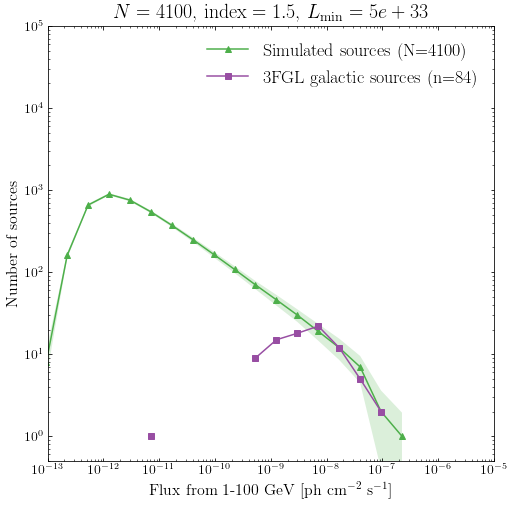

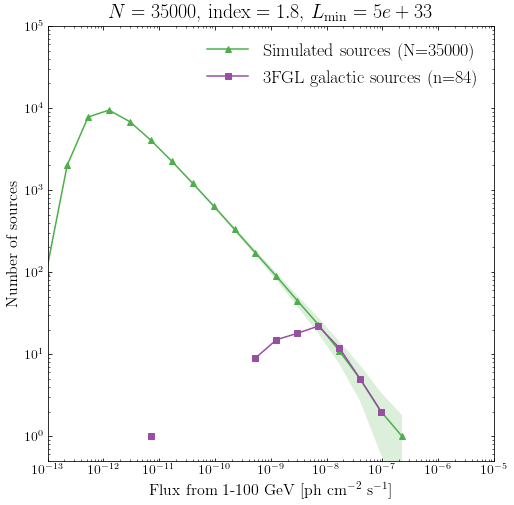

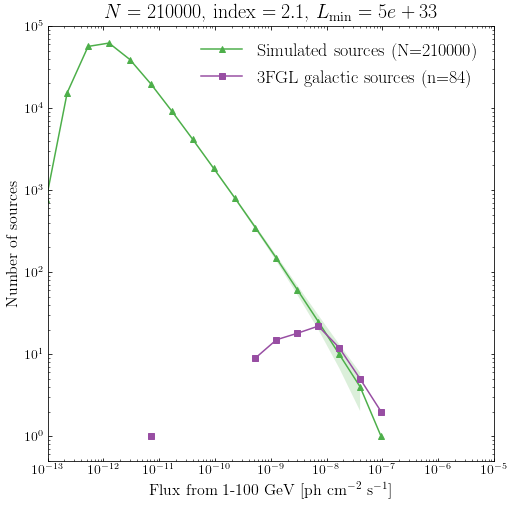

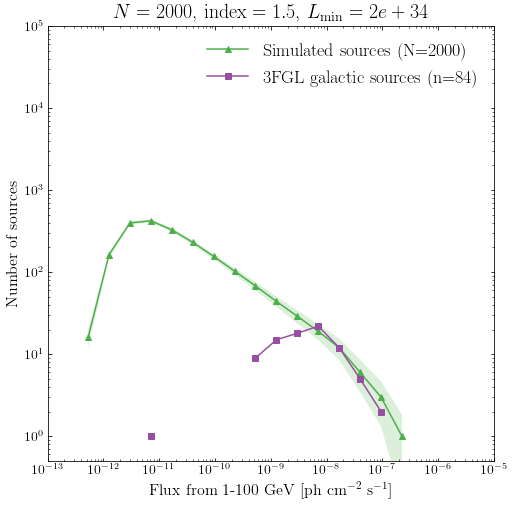

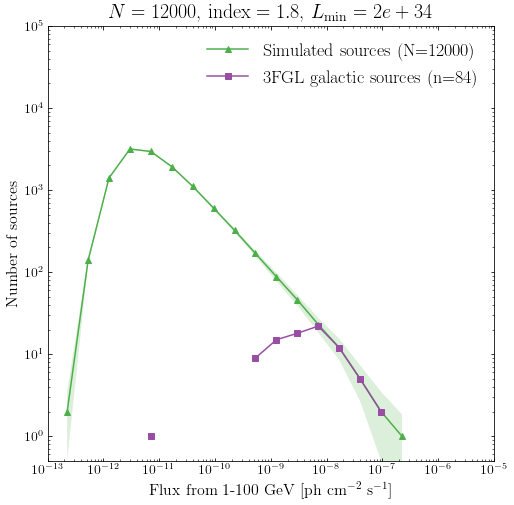

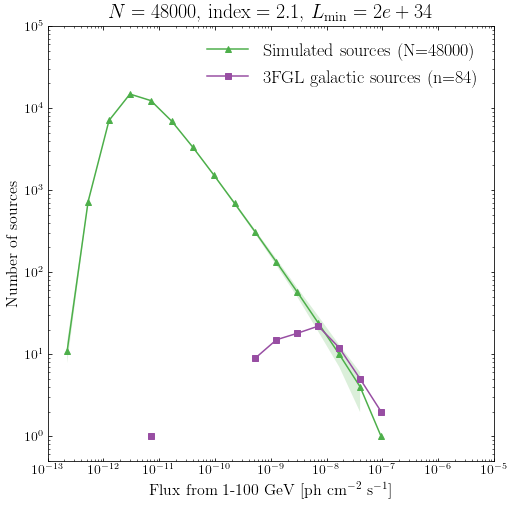

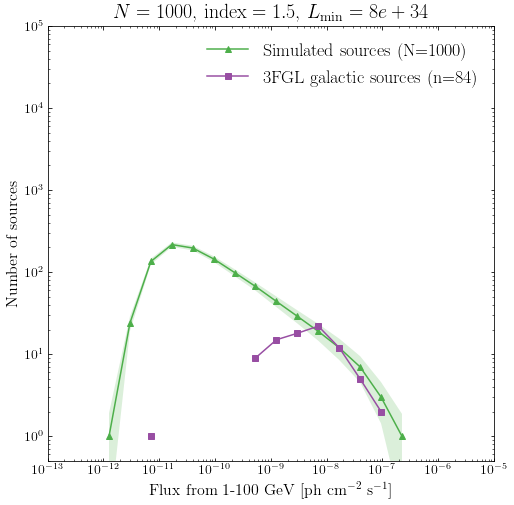

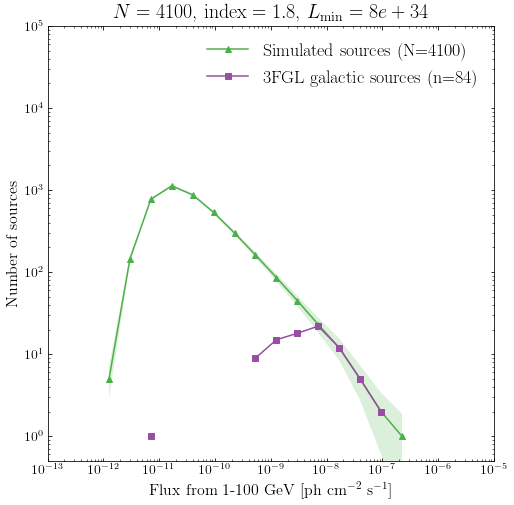

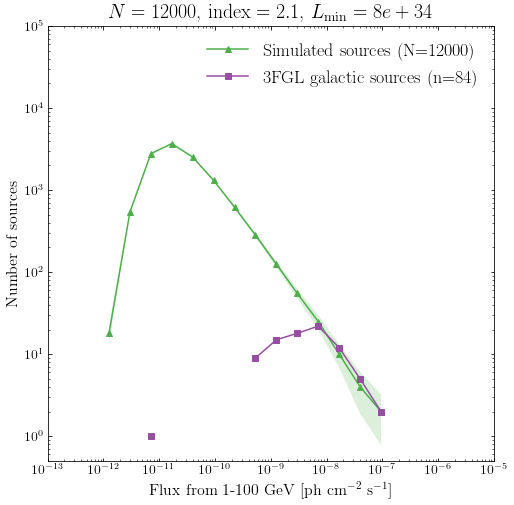

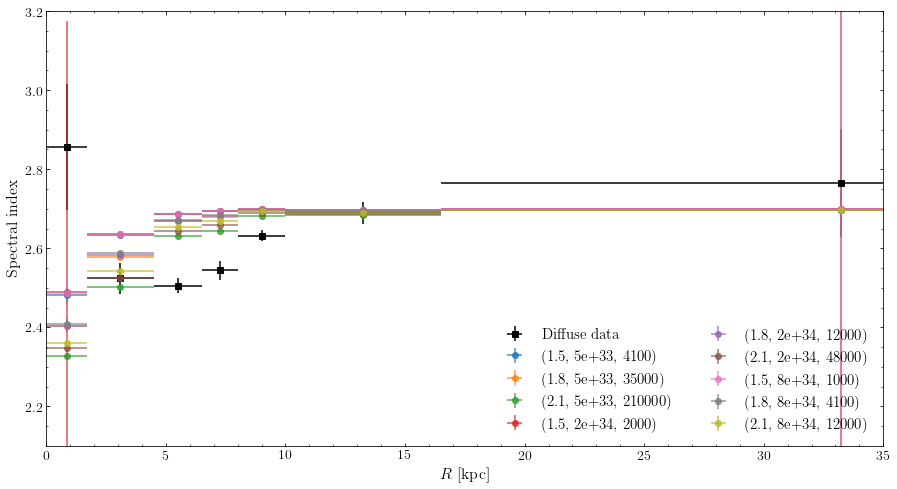

In [45]:
###Only SNR/spp/pwn population
### Do several mock galaxies with different luminosity function/no. sources

###These options showed to reproduce the number of sources at high flux
options = [(30000,1.8,2e34),(10000,1.8,2e34),(10000,2.1,1e35),(120000,2.1,1e34),(3000,1.5,5e33),
           (60000,2.1,2e34)]

ind = []
ind_err = []
frac_op = []
std_frac_op = []
L_min = [5e33,1e34,2e34,5e34,1e35]
aa = [1.5,1.6,1.7,1.8,1.9,2.0,2.1]
L_max = [1e38,5e38,1e39,2e39]
L_min = [5e33,4e34,1e35]
aa = [1.5,1.8,2.1]
L_max = [5e38]
Lmax = 5e38
options = []
Nft = 41
ft = 5e-9
Dmin = 6.*kpc

Dmax = 8*kpc

options = [(1.5,5e33,4100),(1.8,5e33,35000),(2.1,5e33,210000),(1.5,2e34,2000),(1.8,2e34,12000),(2.1,2e34,48000),
          (1.5,8e34,1000),(1.8,8e34,4100),(2.1,8e34,12000)]

for op in options:
    a,Lmin,N = op
    R_spec1,std_R1,lb_frac,std_lb_frac = ave_samples(500,Nsnr=N,LF_i_snr=a,
                                        Lmin_snr=Lmin,Lmax_snr=Lmax,
                                        plothist=True,printstatements=False,
                                       alpha=alp,beta=bet,H=H,
                                       hist_3fgl=hist_3fgl_snr,ft=5e-9,spectrum=intp_3fgl_snr_normed)
    l1, l1_err = plot_spec(R_spec1,std_R1,plot=False)
    ind.append(l1)
    ind_err.append(l1_err)
    frac_op.append(lb_frac)
    std_frac_op.append(std_lb_frac)
# for Lmin in L_min:
#     for a in aa:
#         for Lmax in L_max:
#             N = Nft*(Lmin**(1-a)-Lmax**(1-a))/((4*np.pi*ft*Dmin**2)**(1-a)-Lmax**(1-a))
#             N = np.rint(N)
#             if N > 500000:
#                 print "Too much sources :("
#                 continue
#             options.append((N,a,Lmin))
#             R_spec1,std_R1,lb_frac,std_lb_frac = ave_samples(10,Nsnr=N,LF_i_snr=a,
#                                         Lmin_snr=Lmin,Lmax_snr=Lmax,
#                                         plothist=True,printstatements=False,
#                                        alpha=alp,beta=bet,H=H,
#                                        hist_3fgl=hist_3fgl_snr,ft=5e-9,spectrum=intp_3fgl_snr_normed)


#             l1, l1_err = plot_spec(R_spec1,std_R1,plot=False)
#             ind.append(l1)
#             ind_err.append(l1_err)
#             frac_op.append(lb_frac)
#             std_frac_op.append(std_lb_frac)
frac_op = np.array(frac_op)
std_frac_op = np.array(std_frac_op)
plot_trend(ind,ind_err,options)


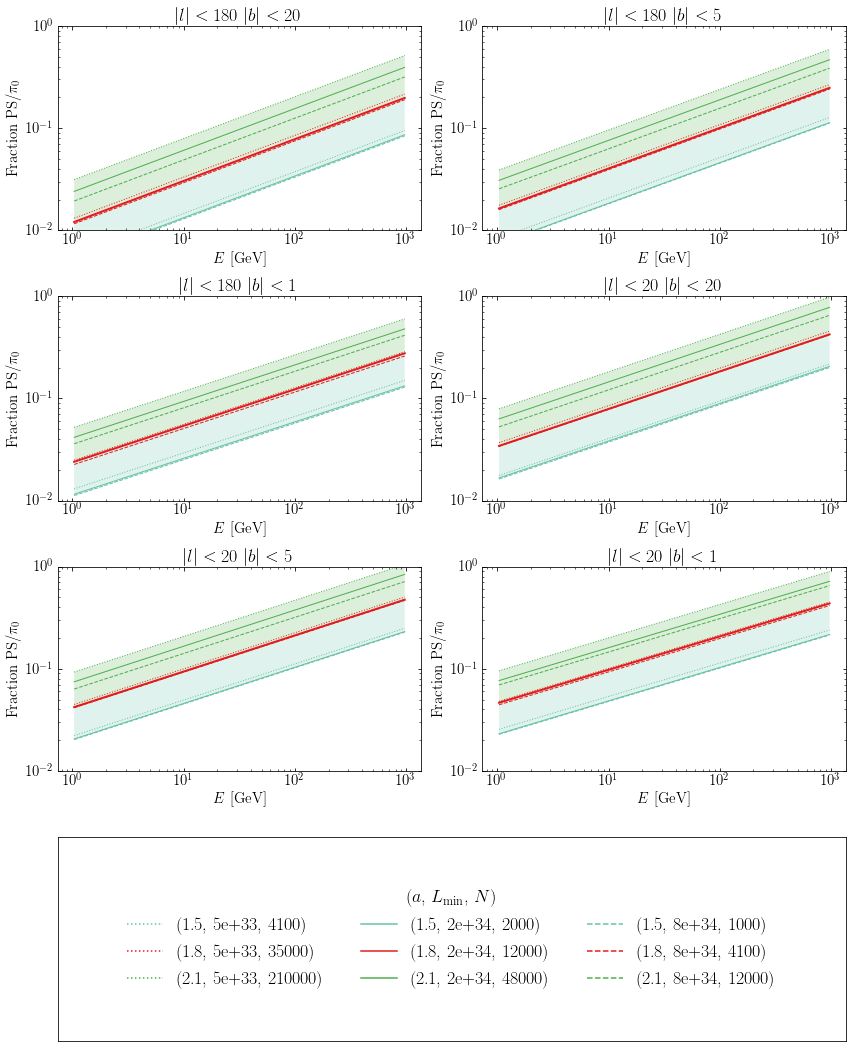

In [44]:
###Plot the fraction of unresolved/diffuse at different l,b

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(4,2)

for di in range(len(lb)):
    #print "At abs(l,b):",lb[di]
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    for i,sf in enumerate(frac_op[:,di]):
        if options[i][0]==1.5:
            #_ls = '-'
            color = colors[0]
        elif options[i][0]==1.8:
            #_ls = '--'
            color = colors[5]
        elif options[i][0]==2.1:
            #_ls = '-.'
            color = colors[2]
        if options[i][1]==5e33:
            #color = colors[5] #red
            _ls = ':'
        elif options[i][1]==2e34:
            #color = colors[0] #blue
            _ls = '-'
        elif options[i][1]== 8e34:
            #color= colors[2] #green
            _ls = '--'
        if options[i][0]==1.8 and options[i][1]==2e34:
            thick = 2
        else:
            thick = 1
        #print options_print[i]
        div = frac_op[i,di]
        ax.loglog(E,div,label=options[i],ls=_ls,color=color,lw=thick)#marker=_ms,ms=1)
        
        #ax.fill_between(E,div-std_frac_op[i,di],div+std_frac_op[i,di],alpha=0.2)#,facecolor=colors[i])
        ax.set_xscale('log',nonposx='clip')
        ax.set_yscale('log',nonposy='clip')
        #print "At %.1f GeV the fraction is %.2f "%(E[iE100],div[iE100])
    ax.fill_between(E,frac_op[2,di],frac_op[4,di],alpha=0.2,facecolor=colors[2])
    ax.fill_between(E,frac_op[6,di],frac_op[4,di],alpha=0.2,facecolor=colors[0])
    ax.set_ylim([0.01,1])
    ax.set_title(r'$|l| < %s \ |b| < %s$'%lb[di],fontsize=18)
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=15)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=15)
    ax.set_ylabel(r'Fraction $\rm PS/ \pi_0$',fontsize=15)
    fig.add_subplot(ax)
    #plt.legend(loc=2,frameon=False,fontsize=15,ncol=2)#, title=options_labels[0:4])
##Plot legend in seperate subplot
gsi = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gs[di+1])

ax = plt.subplot(gs[-1,:]) 

ax.set_frame_on(True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i,sf in enumerate(frac_op[:,di]):      
    div = frac_op[i,di]
    if options[i][0]==1.5:
        #_ls = '-'
        color = colors[0]
    elif options[i][0]==1.8:
        #_ls = '--'
        color = colors[5]
    elif options[i][0]==2.1:
        #_ls = '-.'
        color = colors[2]
    if options[i][1]==5e33:
        #color = colors[5] #red
        _ls = ':'
    elif options[i][1]==2e34:
        #color = colors[0] #blue
        _ls = '-'
    elif options[i][1]== 8e34:
        #color= colors[2] #green
        _ls = '--'
    ax.plot(0,0,label=options[i],ls=_ls,color=color)
    
fig.add_subplot(ax)
lg = plt.legend(loc=10,title=r'($a$, $L_{\rm min}$, $N$)',frameon=False,ncol=3,fontsize=18)
lg.get_title().set_fontsize(18)
#fig2.suptitle(r'PS index = %s, diffuse index = 2.52-2.61'%(snr_index),fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('fraction_ps_diffuse.pdf')